In [125]:
import scvelo as scv
import scanpy as sc
import cellrank as cr
import loompy as lp

import numpy as np
import pandas as pd
import re

import os

scv.settings.verbosity = 3
scv.settings.set_figure_params('scvelo')
cr.settings.verbosity = 2

In [126]:
import warnings
warnings.simplefilter('ignore', category=UserWarning)
warnings.simplefilter('ignore', category=FutureWarning)
warnings.simplefilter('ignore', category=DeprecationWarning)

In [127]:
os.chdir('/research/peer/fdeckert/FD20200109SPLENO')

# Import velocyto loom 

In [ ]:
# Import velocyto loom as anndata
adata = scv.read_loom('data/object/velocyto.loom')
if not adata.var_names.is_unique: adata.var_names_make_unique()

# Meta data

In [ ]:
# QC meta data 
meta = pd.read_csv('data/object/seurat/meta/meta.csv', index_col=0)

# Filter adata by meta CellID and merge
adata = adata[meta.index]
adata.obs = adata.obs.merge(meta, how='left', left_index=True, right_index=True, suffixes=('', ''))

In [ ]:
adata.obs['sample_name'] = adata.obs['sample_name'].astype('category')

# Proportions 

In [ ]:
scv.pl.proportions(adata, groupby='sample_name')

# Split adata by treatment group

In [ ]:
adata_1 = adata[(adata.obs['treatment'] == 'NaCl')].copy()
adata_2 = adata[(adata.obs['treatment'] == 'CpG')].copy()

# Import UMAP embeddings

In [ ]:
umap_1 = pd.read_csv('data/object/seurat_sct_nacl/reductions/umap/reduction.csv', index_col=0)
umap_1 = umap_1[np.isin(umap_1.index, adata_1.obs.index)]
umap_1 = umap_1.reindex(adata_1.obs.index).to_numpy()
adata_1.obsm['X_umap'] = umap_1

umap_2 = pd.read_csv('data/object/seurat_sct_cpg/reductions/umap/reduction.csv', index_col=0)
umap_2 = umap_2[np.isin(umap_2.index, adata_2.obs.index)]
umap_2 = umap_2.reindex(adata_2.obs.index).to_numpy()
adata_2.obsm['X_umap'] = umap_2

# Filter and normalize 

In [ ]:
scv.pp.filter_and_normalize(adata_1, min_shared_counts=20, n_top_genes=2000)
sc.tl.pca(adata_1)
sc.pp.neighbors(adata_1, n_pcs=30, n_neighbors=30)

scv.pp.filter_and_normalize(adata_2, min_shared_counts=20, n_top_genes=2000)
sc.tl.pca(adata_2)
sc.pp.neighbors(adata_2, n_pcs=30, n_neighbors=30)

# Compute RNA velocity

In [ ]:
scv.pp.moments(adata_1, n_pcs=30, n_neighbors=30)
scv.pp.moments(adata_2, n_pcs=30, n_neighbors=30)

In [ ]:
scv.tl.recover_dynamics(adata_1, n_jobs=8)
scv.tl.recover_dynamics(adata_2, n_jobs=8)

In [ ]:
scv.tl.velocity(adata_1, mode='dynamical')
scv.tl.velocity(adata_2, mode='dynamical')

In [ ]:
scv.tl.velocity_graph(adata_1)
scv.tl.velocity_graph(adata_2)

# Save/load results 

In [129]:
adata_1.write('data/object/seurat_sct_nacl/scvelo.h5ad')
adata_2.write('data/object/seurat_sct_cpg/scvelo.h5ad')

# adata_1 = sc.read_h5ad('data/object/seurat_sct_nacl/scvelo.h5ad')
# adata_2 = sc.read_h5ad('data/object/seurat_sct_cpg/scvelo.h5ad')

# Velocity stream 

computing velocity embedding
    finished (0:00:06) --> added
    'velocity_umap', embedded velocity vectors (adata.obsm)


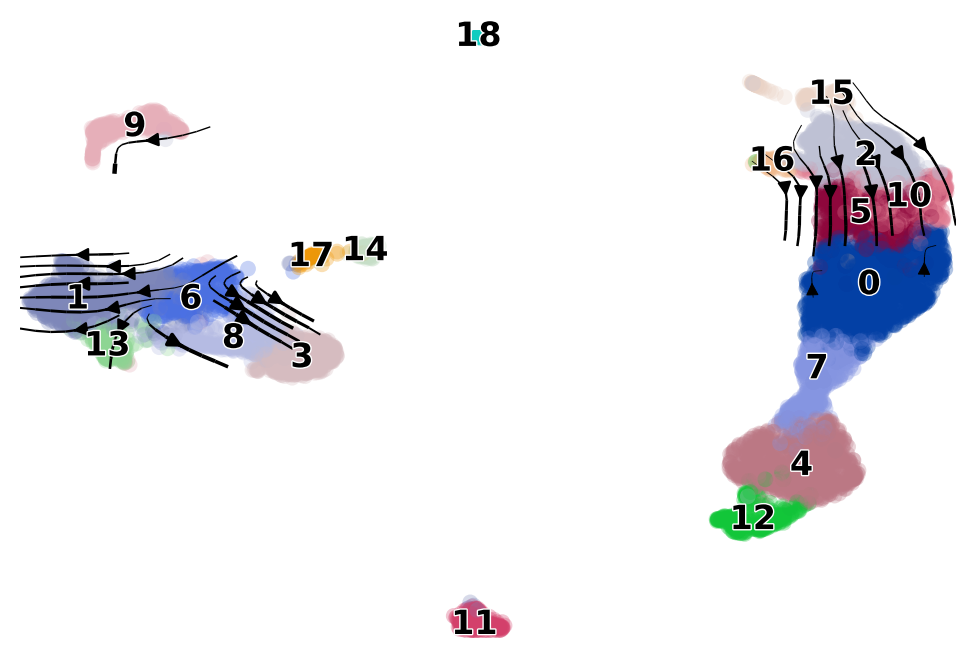

computing velocity embedding
    finished (0:00:10) --> added
    'velocity_umap', embedded velocity vectors (adata.obsm)


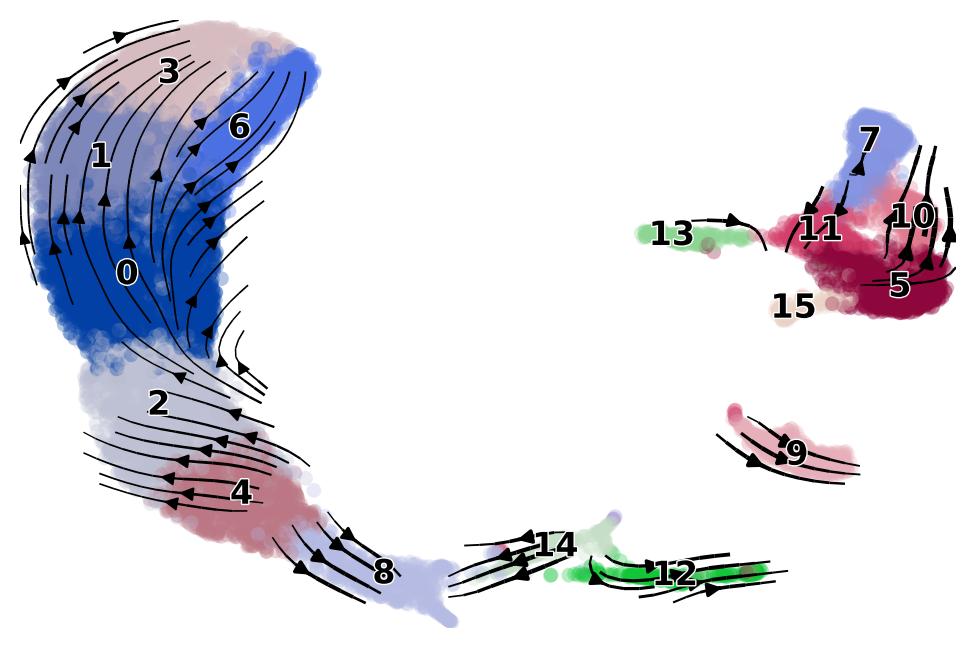

In [132]:
scv.pl.velocity_embedding_stream(adata_1, basis="umap", legend_fontsize=12, title="", smooth=0.8, min_mass=4, color = "SCT_snn_res.0.8")
scv.pl.velocity_embedding_stream(adata_2, basis="umap", legend_fontsize=12, title="", smooth=0.8, min_mass=4, color = "SCT_snn_res.0.8")

# Identify terminal states

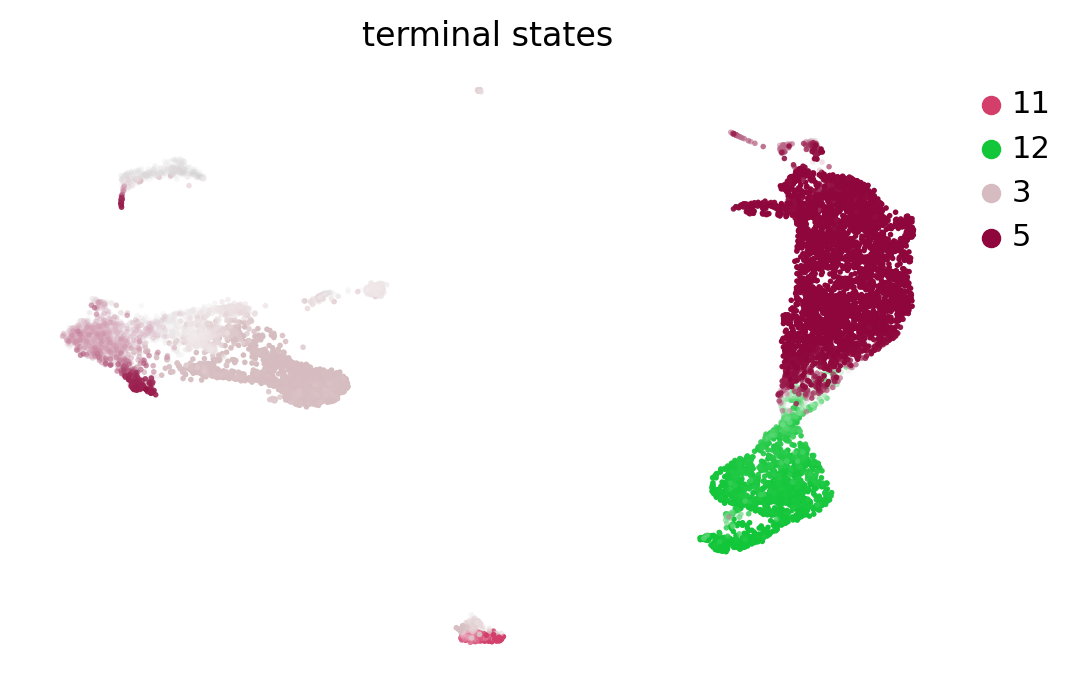

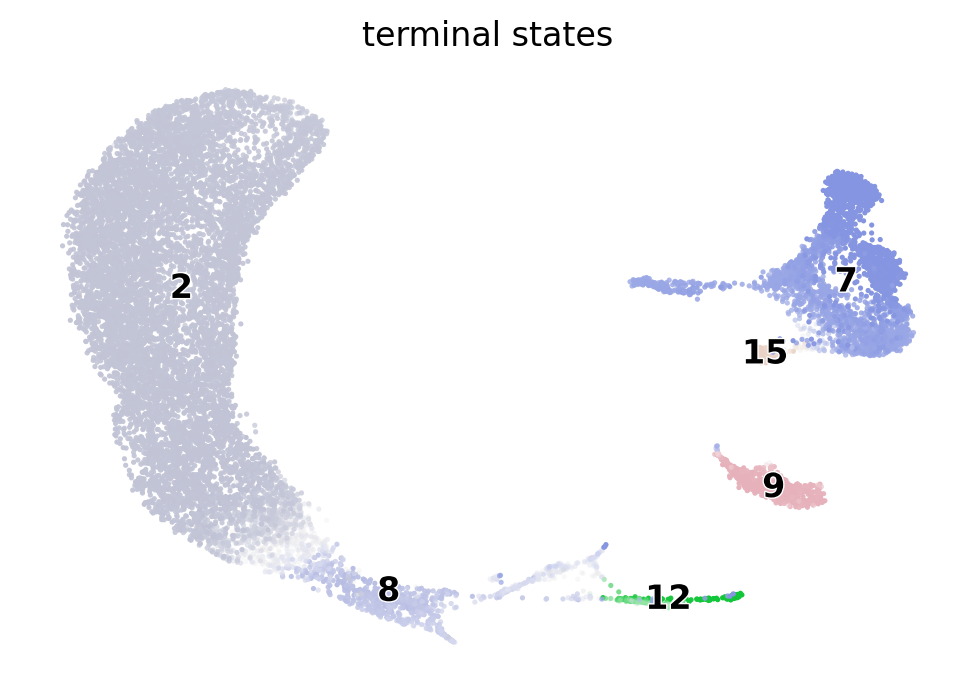

In [136]:
cr.pl.terminal_states(adata_1)
cr.pl.terminal_states(adata_2)

# Identify initial states

In [135]:
cr.tl.initial_states(adata_1, cluster_key="SCT_snn_res.0.8")
cr.tl.initial_states(adata_2, cluster_key="SCT_snn_res.0.8")

Computing transition matrix based on logits using `'deterministic'` mode
Estimating `softmax_scale` using `'deterministic'` mode


Setting `softmax_scale=6.2546`


    Finish (0:00:52)
Using a connectivity kernel with weight `0.2`
Computing transition matrix based on `adata.obsp['connectivities']`
    Finish (0:00:00)
Computing eigendecomposition of the transition matrix
Adding `adata.uns['eig_bwd']`
       `.eigendecomposition`
    Finish (0:00:01)
Computing Schur decomposition
When computing macrostates, choose a number of states NOT in `[4]`
Adding `adata.uns['eig_bwd']`
       `.eigendecomposition`
       `.schur`
       `.schur_matrix`
    Finish (0:00:00)
Computing `6` macrostates
Adding `.macrostates_memberships`
       `.macrostates`
       `.schur`
       `.coarse_T`
       `.coarse_stationary_distribution`
    Finish (0:00:04)
Adding `adata.obs['initial_states_probs']`
       `adata.obs['initial_states']`
       `adata.obsm['macrostates_bwd']`
       `.terminal_states_probabilities`
       `.terminal_states`
    Finish
Computing transition matrix based on logits using `'deterministic'` mode
Estimating `softmax_scale` using `'determinist

Setting `softmax_scale=4.2185`


    Finish (0:01:27)
Using a connectivity kernel with weight `0.2`
Computing transition matrix based on `adata.obsp['connectivities']`
    Finish (0:00:00)
Computing eigendecomposition of the transition matrix
Adding `adata.uns['eig_bwd']`
       `.eigendecomposition`
    Finish (0:00:01)
Computing Schur decomposition
Adding `adata.uns['eig_bwd']`
       `.eigendecomposition`
       `.schur`
       `.schur_matrix`
    Finish (0:00:00)
Computing `2` macrostates
Adding `.macrostates_memberships`
       `.macrostates`
       `.schur`
       `.coarse_T`
       `.coarse_stationary_distribution`
    Finish (0:00:00)
Adding `adata.obs['initial_states_probs']`
       `adata.obs['initial_states']`
       `adata.obsm['macrostates_bwd']`
       `.terminal_states_probabilities`
       `.terminal_states`
    Finish


# Compute fate maps

In [137]:
cr.tl.lineages(adata_1)
cr.tl.lineages(adata_2)

Computing lineage probabilities towards terminal states
Computing absorption probabilities


Adding `adata.obsm['to_terminal_states']`
       `.absorption_probabilities`
    Finish (0:00:16)
Adding lineages to `adata.obsm['to_terminal_states']`
    Finish (0:00:16)
Computing lineage probabilities towards terminal states
Computing absorption probabilities


Adding `adata.obsm['to_terminal_states']`
       `.absorption_probabilities`
    Finish (0:00:18)
Adding lineages to `adata.obsm['to_terminal_states']`
    Finish (0:00:18)


# Initialize velocity kernel 

In [138]:
from cellrank.tl.kernels import VelocityKernel
vk = VelocityKernel(adata_1).compute_transition_matrix()

Computing transition matrix based on logits using `'deterministic'` mode
Estimating `softmax_scale` using `'deterministic'` mode


Setting `softmax_scale=6.2546`


    Finish (0:00:35)


# Initialize connectivity kernel 

In [139]:
from cellrank.tl.kernels import ConnectivityKernel
ck = ConnectivityKernel(adata_1).compute_transition_matrix()

Computing transition matrix based on `adata.obsp['connectivities']`
    Finish (0:00:00)


# Combine kernel 

In [140]:
combined_kernel = 0.8 * vk + 0.2 * ck

# Initialize estimator 

In [141]:
from cellrank.tl.estimators import GPCCA
g = GPCCA(combined_kernel)

Computing Schur decomposition
When computing macrostates, choose a number of states NOT in `[14]`
Adding `adata.uns['eig_fwd']`
       `.eigendecomposition`
       `.schur`
       `.schur_matrix`
    Finish (0:00:01)


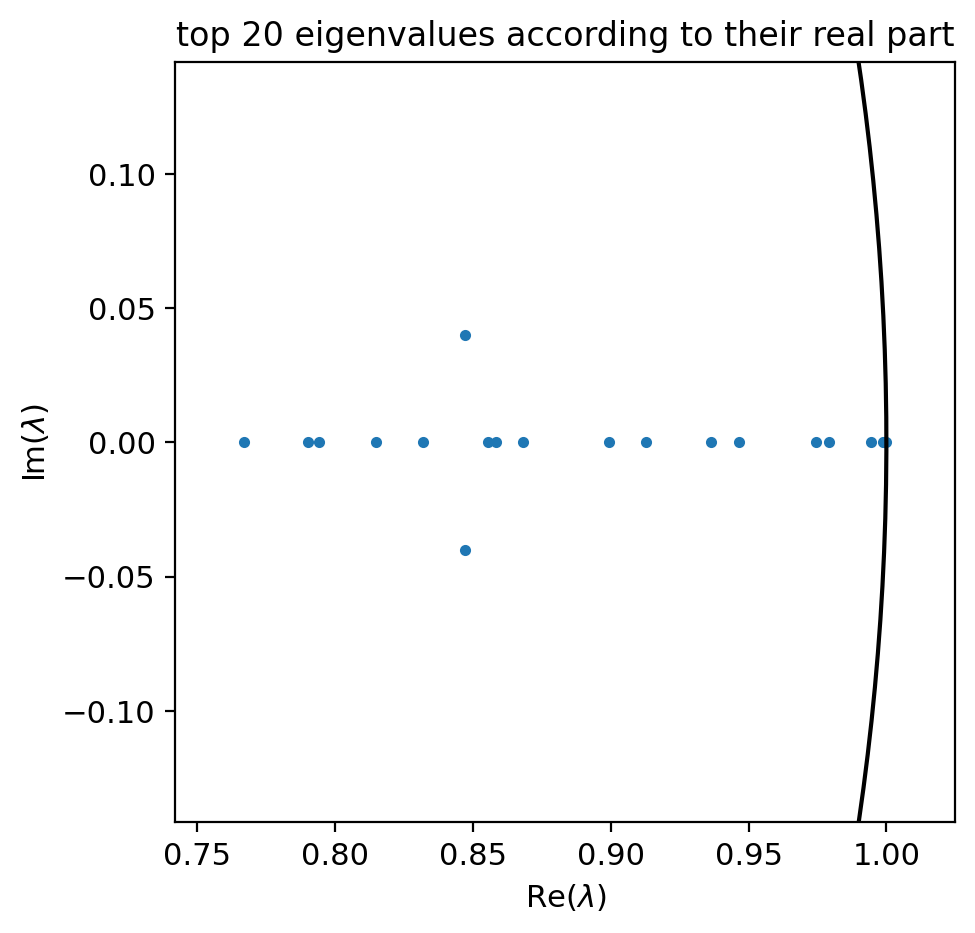

In [142]:
g.compute_schur(n_components=20)
g.plot_spectrum()

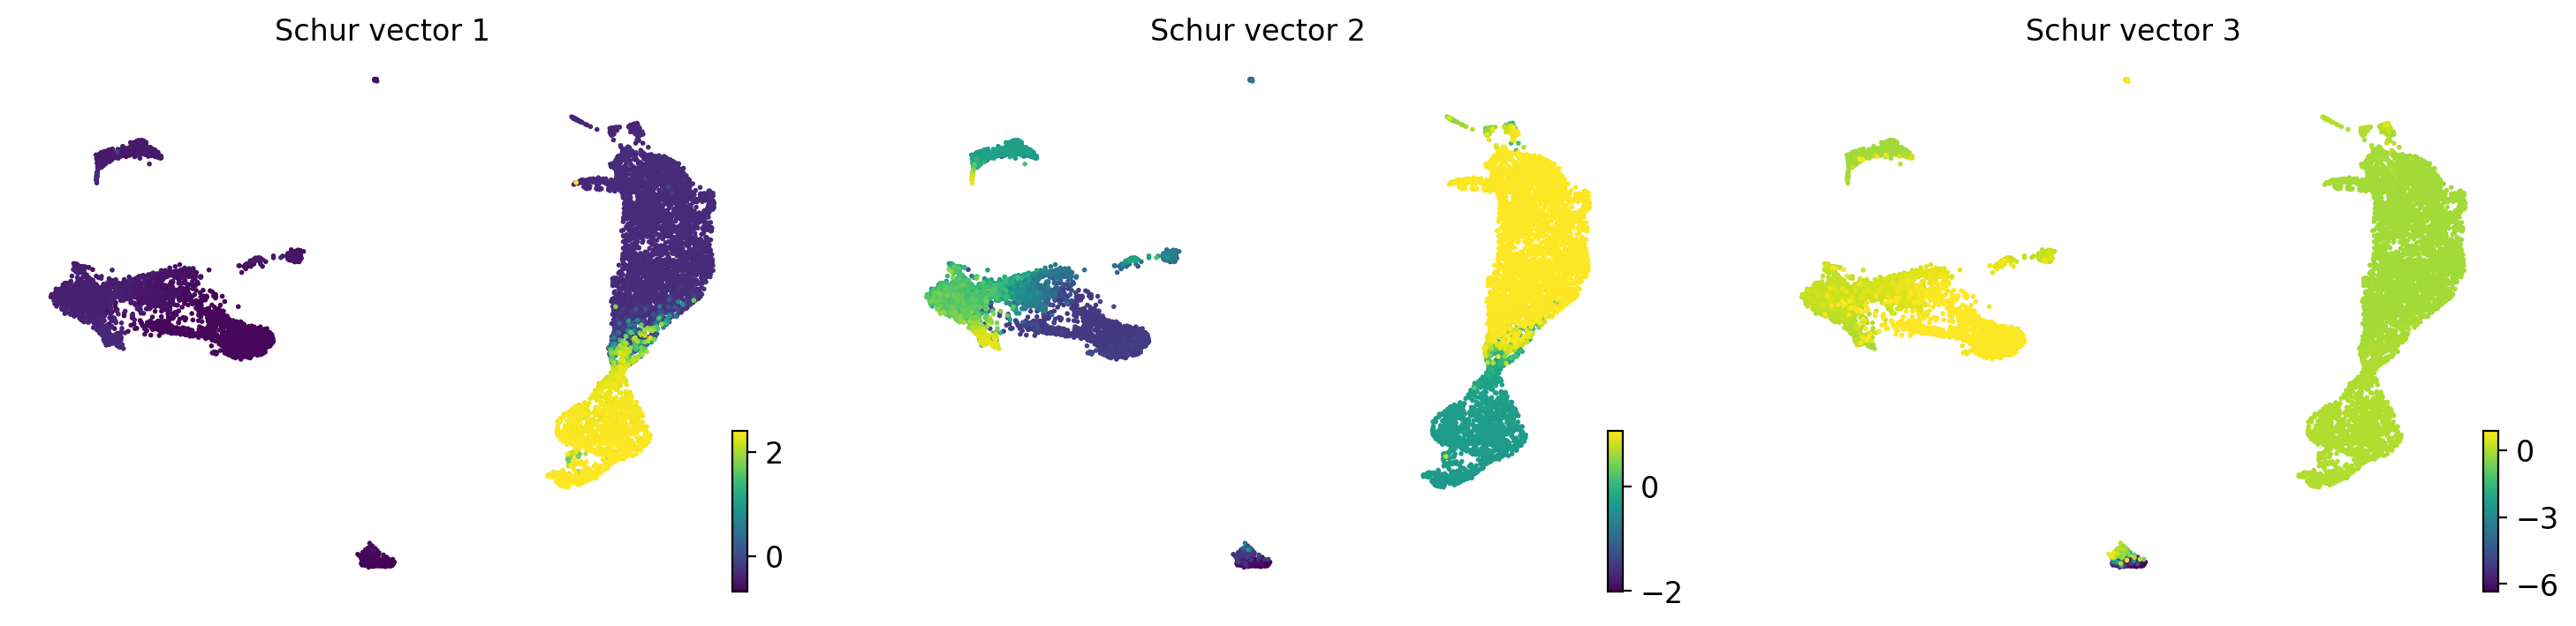

In [143]:
g.plot_schur(use=3)

Computing `3` macrostates
Adding `.macrostates_memberships`
       `.macrostates`
       `.schur`
       `.coarse_T`
       `.coarse_stationary_distribution`
    Finish (0:00:00)


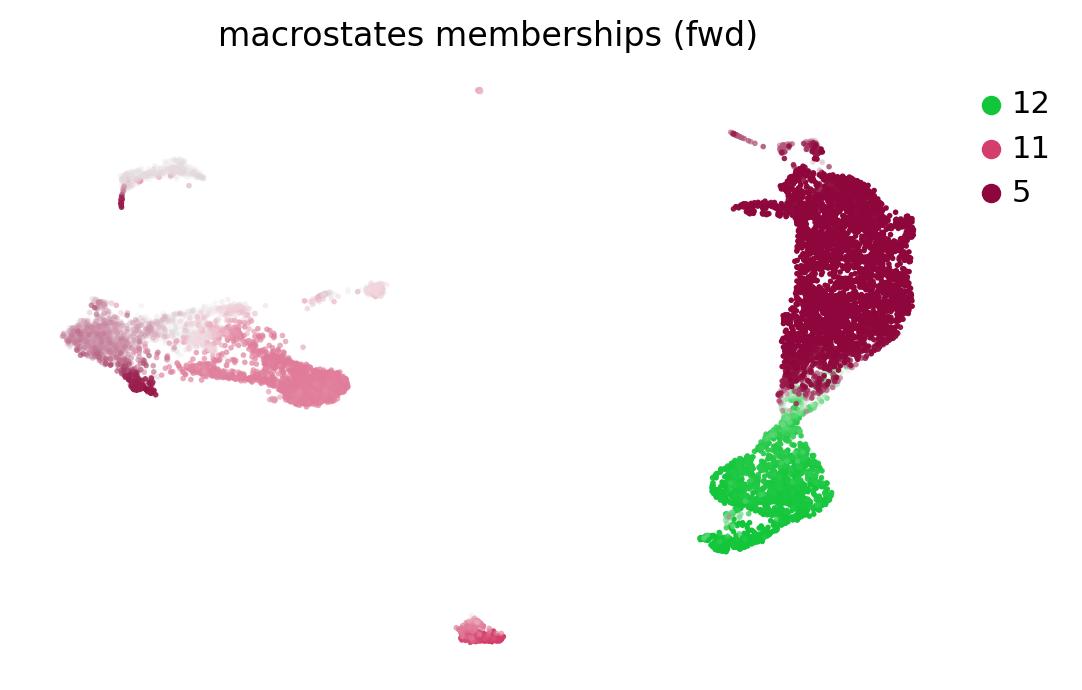

In [144]:
g.compute_macrostates(n_states=3, cluster_key="SCT_snn_res.0.8")
g.plot_macrostates()

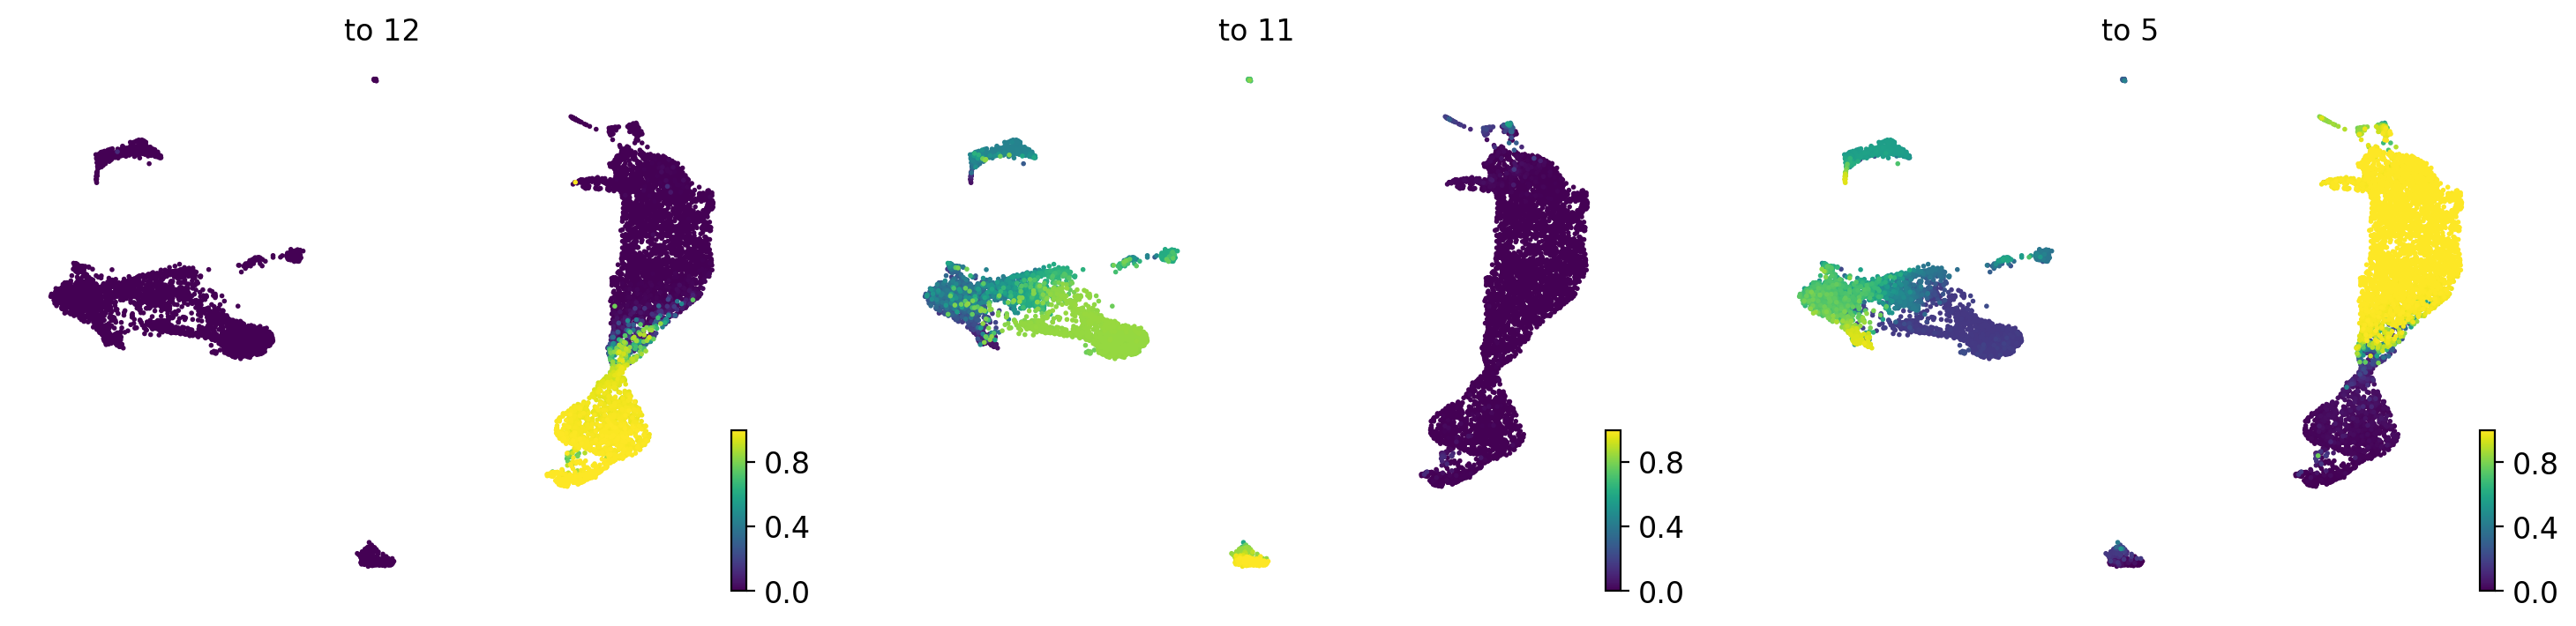

In [146]:
g.plot_macrostates(same_plot=False)